In [87]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
import math
import rasterio


In [88]:
# Load proximity data
coast_prox = rasterio.open("data/qgis/proximity-coast-line.tif")
powerline_prox = rasterio.open("data/qgis/proximity-power-line.tif")

In [89]:
powerline_prox.read(1)

array([[-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       ...,
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38]], dtype=float32)

In [90]:
# Load projected wind prediction
# Currently just using wind atlas data
cap_factor = rasterio.open("data/predictions/wind_projected.tif")

In [91]:
# Load water temp predictions and stations data
water_temp_stations = gpd.read_file('data/fmi/water_temp_stations.geojson')
# Project for distance calc
water_temp_stations_proj = water_temp_stations.to_crs("EPSG:3067")
water_temp_pred = pd.read_csv('data/predictions/water_preds.csv').rename(
    columns={"Station": "name", "Prediction": "water_temp"})
water_temp_stations = water_temp_stations.merge(water_temp_pred, on="name")
water_temp_stations

,name,geometry,water_temp
0,Kemi Ajos,POINT (24.51526 65.67337),6.629967
1,Raahe Lapaluoto,POINT (24.40708 64.66630),6.967584
2,Porvoo Emäsalo Vaarlahti,POINT (25.62509 60.20579),7.612832
3,Helsinki Kaivopuisto,POINT (24.95622 60.15363),7.761681
4,Vaasa Vaskiluoto,POINT (21.57118 63.08150),7.319557
5,Rauma Petäjäs,POINT (21.44263 61.13390),6.030093
6,Turku Ruissalo Saaronniemi,POINT (22.10053 60.42828),8.147957
7,Oulu Toppila,POINT (25.41820 65.04030),5.240790
8,Pietarsaari Leppäluoto,POINT (22.68958 63.70857),7.270417
9,Kaskinen Ådskär,POINT (21.21483 62.34395),3.203901


In [92]:
# Load weather predictions and stations
weather_stations = gpd.read_file('data/fmi/weather_stations.geojson')
weather_stations_proj = weather_stations.to_crs("EPSG:3067")
air_temp_pred = pd.read_csv('data/predictions/air_preds.csv').rename(
    columns={"Station": "name", "Prediction": "air_temp"})
wind_pred = pd.read_csv('data/predictions/wind_preds.csv').rename(
    columns={"Station": "name", "Prediction": "wind_speed"})
weather = (
    weather_stations
    .merge(wind_pred, on="name", how='outer')
    .merge(air_temp_pred, on="name", how='outer'))
display(weather)
display(weather[weather['geometry'].isna()])
weather.dropna(inplace=True)

,name,geometry,wind_speed,air_temp
0,Alajärvi Möksy,POINT (24.26084 63.08898),0.000000,1.138938
1,Asikkala Pulkkilanharju,POINT (25.52021 61.26521),3.123616,4.235330
2,Eckerö Torp,None,0.000000,0.000000
3,Enontekiö Kilpisjärvi Saana,POINT (20.85091 69.04277),6.567162,-3.044804
4,Enontekiö Kilpisjärvi kyläkeskus,POINT (20.81379 69.03905),3.627882,-2.390573
...,...,...,...,...
227,Virolahti Koivuniemi,POINT (27.67274 60.52720),2.454944,3.252385
228,Virrat Äijänneva,POINT (23.54228 62.32783),2.449347,1.764792
229,Ylitornio Meltosjärvi,POINT (24.64960 66.52952),3.015766,-0.993749
230,Ylivieska lentokenttä,POINT (24.72468 64.05029),2.662563,0.635277


,name,geometry,wind_speed,air_temp
2,Eckerö Torp,None,0.000000,0.000000
8,Espoo Sepänkylä,None,2.900659,3.396618
27,Helsinki Rautatientori,None,0.000000,6.924984
32,Hämeenlinna Lammi Evo,None,1.803582,1.804744
53,Joroinen Varkaus lentoasema,None,1.943659,2.057693
79,Kemiönsaari Lövböle,None,0.000000,0.000000
83,Kittilä Levitunturi,None,8.369637,-0.123243
115,Lahti Laune,None,0.915993,2.476491
137,Muonio Alamuonio,None,0.000000,-0.890871
166,Puumala kirkonkylä Hiisivuori,None,0.000000,3.810227


In [93]:
# Min & max for normalization
min_water_temp = water_temp_stations['water_temp'].min()
max_water_temp = water_temp_stations['water_temp'].max()
water_spread = max_water_temp - min_water_temp
min_air_temp = weather['air_temp'].min()
max_air_temp = weather['air_temp'].max()

In [94]:
# Input: any arbitrary point

def score(long, lat, verbose=False):
    eps = 0.00001
    point = Point(long, lat)

    # Factor 1: sea water cooling
    coast_dist = next(coast_prox.sample([(long, lat)]))[0]
    closest_water = water_temp_stations.iloc[water_temp_stations_proj.distance(point).idxmin()]
    # water prox score: sqrt(normalized_temp * (1/log(distance)))
    score_water_temp = (max_water_temp - closest_water['water_temp'])/ water_spread # 0-1
    score_water_prox = math.sqrt(score_water_temp * (1/max(1, math.log(coast_dist + eps))))
    if verbose: print(
        f"{long=:.2f} {lat=:.2f} {coast_dist=:.2f} water_temp={closest_water['water_temp']:.2f} "
        f"{score_water_temp=:.2f} {score_water_prox=:.4f}"
    )

    # Factor 2: close to existing power infra
    powerline_dist = next(powerline_prox.sample([(long, lat)]))[0]
    if powerline_dist < 0:
        powerline_dist = 99999
    score_powerline_prox = (1/max(1, math.log(powerline_dist + eps)))
    if verbose: print(f"{long=:.2f} {lat=:.2f} {powerline_dist=:.2f} {score_powerline_prox=:.4f}")

    # Factor 3: air temp for air cooling
    closest_weather = weather.iloc[weather_stations_proj.distance(point).idxmin()]
    # Normalize to 0-1
    score_temp = (
        (weather['air_temp'].max() - closest_weather['air_temp'])
        / (weather['air_temp'].max() - weather['air_temp'].min())
    )
    if verbose: print(f"{long=:.2f} {lat=:.2f} air_temp={closest_weather['air_temp']:.2f} {score_temp=:.4f}")

    # Factor 4: wind speed for power generation
    score_cap_factor = next(cap_factor.sample([(long, lat)]))[0]
    if verbose: print(f"{long=:.2f} {lat=:.2f} {score_cap_factor=:.4f}")

    # Final: linearly add all factors
    score_final = (
        0.2 * score_water_prox
        + 0.2 * score_powerline_prox
        + 0.3 * score_temp
        + 0.3 * score_cap_factor
    )
    return score_final, score_water_prox, score_powerline_prox, score_temp, score_cap_factor

score(26.0, 68.0, verbose=True)


long=26.00 lat=68.00 coast_dist=779.43 water_temp=6.28 score_water_temp=0.45 score_water_prox=0.2610
long=26.00 lat=68.00 powerline_dist=115.41 score_powerline_prox=0.2106
long=26.00 lat=68.00 air_temp=-2.90 score_temp=0.9879
long=26.00 lat=68.00 score_cap_factor=0.3714


(0.5021170164515059,
 0.2610489907677199,
 0.2105923270456515,
 0.9879391699620568,
 0.3713566730007152)

In [95]:
# Iterate through all possible locations
# bbox 58.85, 19.09, 70.09, 31.58

# (long, lat, final, water, powerline, temp, wind)
results = []

for long in np.arange(19.09, 31.58, 0.05):
    for lat in np.arange(58.85, 70.09, 0.05):
        results.append((long, lat, *score(long, lat)))
        

<Axes: >

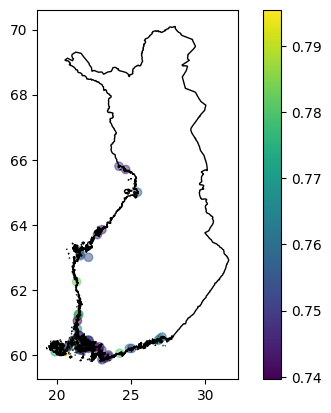

In [96]:
_df = pd.DataFrame(
    results, columns=["long", "lat", "score", "water", "powerline", "temp", "wind"]
)
gdf = gpd.GeoDataFrame(_df, geometry=gpd.points_from_xy(_df.long, _df.lat), crs="EPSG:4326").drop(columns=["long", "lat"])

bound = gpd.read_file('data/wind/finland.geojson')
map_ = bound.plot(color='none', edgecolor='black', zorder=2)
(
    gdf
    .sort_values(by="score", ascending=False)
    .head(50)
    .plot(ax=map_, column="score", legend=True, figsize=(10, 10), alpha=0.5)
)